         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

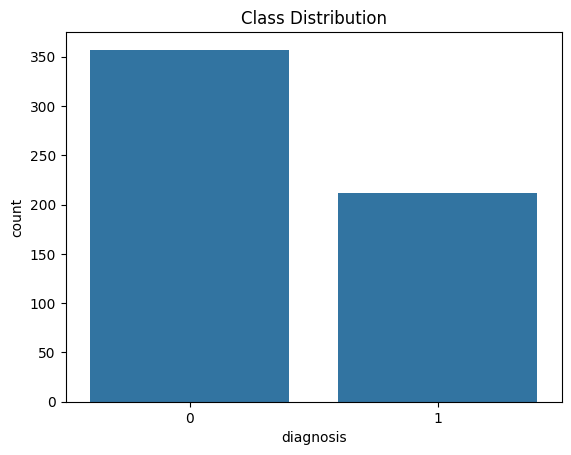

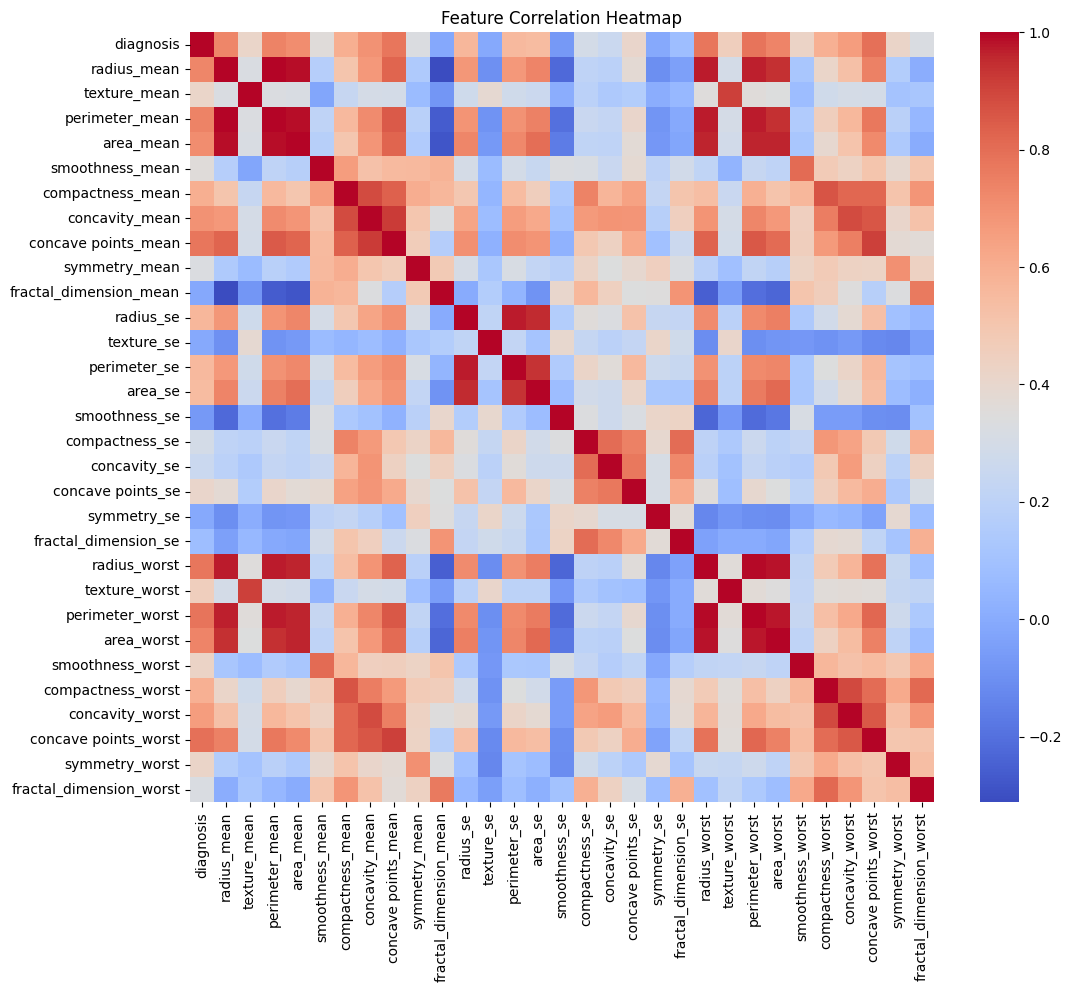


RandomForest Model
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

ROC-AUC Score: 0.9953


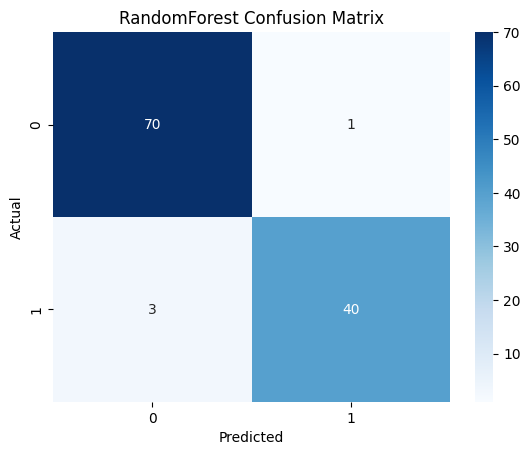


GradientBoosting Model
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

ROC-AUC Score: 0.9951


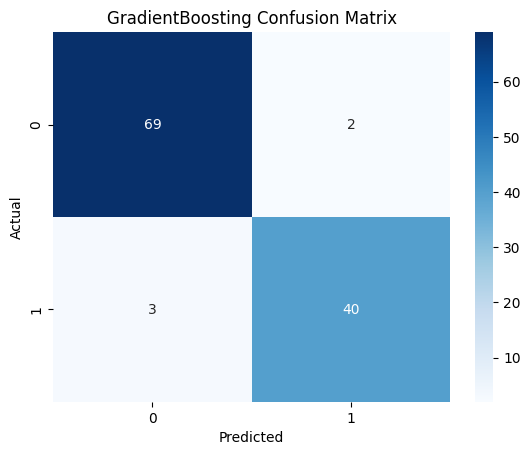


SVM Model
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

ROC-AUC Score: 0.9974


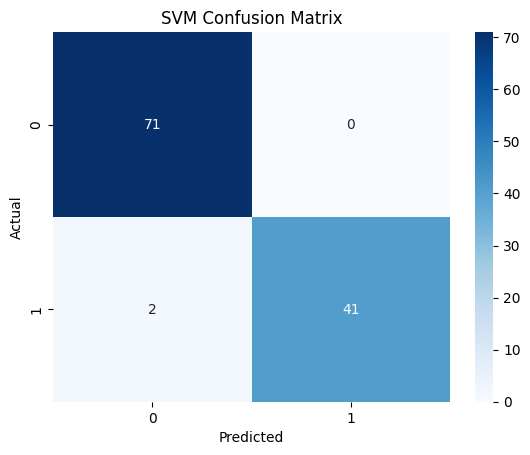


Best Parameters for SVM:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Final SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Final SVM ROC-AUC Score: 0.9974


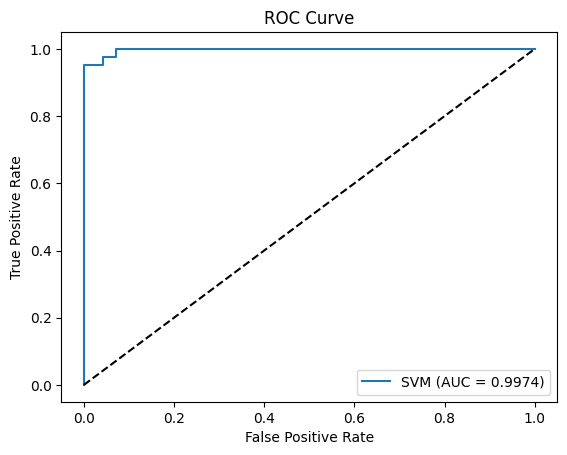

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf

# Load dataset
file_path = '/content/BreastCancer.csv'
data = pd.read_csv(file_path)

# Data overview
print(data.head())
print(data.info())
print(data.describe())

# Check for missing values
print(data.isnull().sum())

# Drop unnecessary columns
if 'Unnamed: 32' in data.columns:
    data.drop(columns=['Unnamed: 32'], inplace=True)
if 'id' in data.columns:
    data.drop(columns=['id'], inplace=True)

# Encode target variable
data['diagnosis'] = data['diagnosis'].map({'B': 0, 'M': 1})

# Visualize class distribution
sns.countplot(x='diagnosis', data=data)
plt.title('Class Distribution')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Select features and target variable
X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define classifiers
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    print(f"\n{name} Model")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC Score: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Hyperparameter tuning for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

print("\nBest Parameters for SVM:")
print(grid_search.best_params_)

# Final evaluation with best parameters
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test)
y_proba_best = best_svm.predict_proba(X_test)[:, 1]

print("\nFinal SVM Classification Report:")
print(classification_report(y_test, y_pred_best))

auc_best = roc_auc_score(y_test, y_proba_best)
print(f"Final SVM ROC-AUC Score: {auc_best:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
